# Superstore Sales Forecasting: An Analytical Pipeline

**Dataset:** Superstore Sales (9,994 order lines, 21 original features)

**Objective:** Predict the revenue generated per order line (the `Sales` variable) using transaction-level attributes.

---

## Analytical Overview

This notebook presents a structured approach to forecasting order-level sales from the Superstore dataset. The analysis proceeds through five phases, each building on the findings of the previous one:

1. **Data Loading and Inspection** -- Understand the structure, types, and quality of the raw data.
2. **Exploratory Data Analysis** -- Characterize the target variable and its relationships with available features through univariate, bivariate, and temporal analyses.
3. **Feature Engineering** -- Construct informative predictors grounded in business logic, temporal patterns, and encoding strategies, while avoiding data leakage.
4. **Baseline and Tuned Models** -- Train Random Forest and XGBoost regressors, tune their hyperparameters, and evaluate multiple training configurations including log-transformed targets and robust loss functions.
5. **Unit Price Proxy Experiment** -- Engineer a price-level feature derived exclusively from historical training data and measure its impact on model accuracy across all price segments.

Each modeling decision is motivated by evidence gathered during exploration, and every result is interpreted in the context of the observed data characteristics.

## 1. Environment Setup

The following cell loads all libraries required throughout the analysis. These include data manipulation tools (pandas, numpy), visualization libraries (matplotlib, seaborn), scikit-learn modules for preprocessing, model training, and evaluation, and the XGBoost gradient boosting library.

A reusable evaluation function is defined here to ensure consistent metric reporting across all experiments. Four metrics are tracked: R-squared (variance explained), Mean Absolute Error (MAE, in dollars), Root Mean Squared Error (RMSE, in dollars), and Symmetric Mean Absolute Percentage Error (SMAPE, scale-independent). This combination allows assessment of both absolute accuracy and proportional accuracy across different sales magnitudes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

try:
    from xgboost import XGBRegressor
except ImportError:
    import subprocess
    subprocess.run(['pip', 'install', 'xgboost', '-q'])
    from xgboost import XGBRegressor

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (13, 5)
plt.rcParams['font.size'] = 10


def evaluate(name, y_true, y_pred):
    """Compute R2, MAE, RMSE, and SMAPE for a given model's predictions."""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    smape = np.mean(
        2 * np.abs(y_pred - y_true) /
        (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    ) * 100
    return {
        "Model": name,
        "R2": round(r2, 4),
        "MAE ($)": round(mae, 2),
        "RMSE ($)": round(rmse, 2),
        "SMAPE (%)": round(smape, 2),
    }


def print_result(name, res):
    """Display a single model's evaluation metrics in a formatted line."""
    print(f"{name:<25} | "
          f"R2 = {res['R2']:.4f} | "
          f"MAE = ${res['MAE ($)']:>8,.2f} | "
          f"RMSE = ${res['RMSE ($)']:>8,.2f} | "
          f"SMAPE = {res['SMAPE (%)']:.1f}%")


results = []
print("Environment ready.")
print(f"XGBoost version: {__import__('xgboost').__version__}")

Environment ready.
XGBoost version: 3.2.0


## 2. Data Loading and Initial Inspection

The dataset is loaded from its CSV source. This initial inspection establishes the dimensions of the data, the names and types of all columns, the presence of missing values, and the basic descriptive statistics of numeric fields. These observations guide the subsequent cleaning and analysis steps.

In [ ]:
df = pd.read_csv('data/Sample - Superstore.csv', encoding='latin1')

print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nColumns:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

df.head()

Shape: 9,994 rows x 21 columns

Columns:
   1. Row ID
   2. Order ID
   3. Order Date
   4. Ship Date
   5. Ship Mode
   6. Customer ID
   7. Customer Name
   8. Segment
   9. Country
  10. City
  11. State
  12. Postal Code
  13. Region
  14. Product ID
  15. Category
  16. Sub-Category
  17. Product Name
  18. Sales
  19. Quantity
  20. Discount
  21. Profit


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'missing': df.isnull().sum(),
    'missing%': (df.isnull().mean() * 100).round(2),
    'unique': df.nunique()
})
print(summary.to_string())

                 dtype  missing  missing%  unique
Row ID           int64        0       0.0    9994
Order ID        object        0       0.0    5009
Order Date      object        0       0.0    1237
Ship Date       object        0       0.0    1334
Ship Mode       object        0       0.0       4
Customer ID     object        0       0.0     793
Customer Name   object        0       0.0     793
Segment         object        0       0.0       3
Country         object        0       0.0       1
City            object        0       0.0     531
State           object        0       0.0      49
Postal Code      int64        0       0.0     631
Region          object        0       0.0       4
Product ID      object        0       0.0    1862
Category        object        0       0.0       3
Sub-Category    object        0       0.0      17
Product Name    object        0       0.0    1850
Sales          float64        0       0.0    5825
Quantity         int64        0       0.0      14


The dataset contains 9,994 rows with no missing values across all 21 columns. This eliminates the need for imputation strategies. The data includes a mix of numeric fields (Sales, Quantity, Discount, Profit) and categorical identifiers (Ship Mode, Segment, Category, Sub-Category, Region, State), along with date fields for order and shipment timing.

In [4]:
print("Numeric descriptive statistics:")
print(df.describe().round(2).to_string())

Numeric descriptive statistics:
        Row ID  Postal Code     Sales  Quantity  Discount   Profit
count  9994.00      9994.00   9994.00   9994.00   9994.00  9994.00
mean   4997.50     55190.38    229.86      3.79      0.16    28.66
std    2885.16     32063.69    623.25      2.23      0.21   234.26
min       1.00      1040.00      0.44      1.00      0.00 -6599.98
25%    2499.25     23223.00     17.28      2.00      0.00     1.73
50%    4997.50     56430.50     54.49      3.00      0.20     8.67
75%    7495.75     90008.00    209.94      5.00      0.20    29.36
max    9994.00     99301.00  22638.48     14.00      0.80  8399.98


Several characteristics are immediately apparent from the descriptive statistics. Sales has a mean of approximately 230 dollars but a median of only 54 dollars, indicating substantial right skew. Profit ranges from large losses (approximately -6,600 dollars) to large gains, with a mean of 29 dollars and a median of only 9 dollars. These distributions will require careful treatment during modeling.

## 3. Data Cleaning

Column names are standardized to lowercase with underscores replacing spaces. This prevents potential issues with inconsistent references throughout the analysis and ensures compatibility with programmatic column access.

In [5]:
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
)
df.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## 4. Univariate Analysis

Univariate analysis examines each variable in isolation to understand its distribution, central tendency, dispersion, and the presence of outliers. This step is essential before modeling because the distributional properties of the target variable directly influence the choice of algorithms, loss functions, and preprocessing transformations.

### 4.1 Target Variable: Sales

The target variable is `Sales`, representing the revenue generated by each order line. Understanding its distribution is the single most important preliminary step, as it determines whether transformations are needed and which error metrics will be most informative.

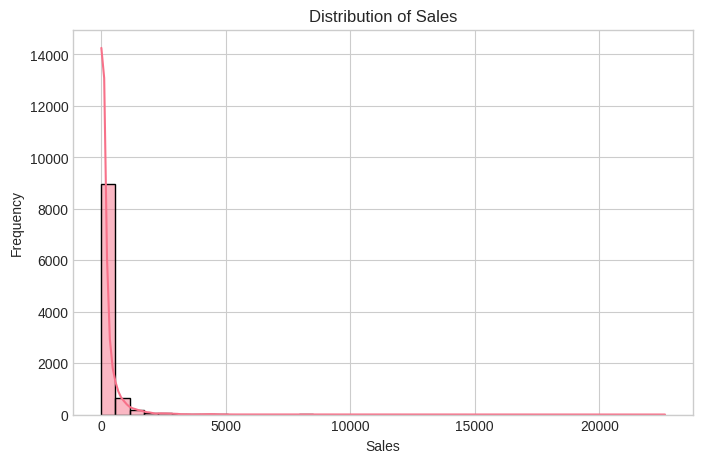

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df['sales'], bins=40, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

The histogram reveals a heavily right-skewed distribution. The vast majority of transactions cluster below 500 dollars, while a long tail of high-value orders extends to over 20,000 dollars. This shape is consistent with the large gap between the mean (230 dollars) and the median (54 dollars) observed in the descriptive statistics.

In [7]:
print(f"Skewness : {df['sales'].skew():.2f}")
print(f"Kurtosis : {df['sales'].kurtosis():.2f}")
print(f"Orders > $2,000 : {(df['sales'] > 2000).sum()} ({(df['sales'] > 2000).mean() * 100:.1f}%)")
print(f"Orders > $5,000 : {(df['sales'] > 5000).sum()} ({(df['sales'] > 5000).mean() * 100:.1f}%)")

Skewness : 12.97
Kurtosis : 305.31
Orders > $2,000 : 140 (1.4%)
Orders > $5,000 : 19 (0.2%)


A skewness of 12.97 and kurtosis of 305.31 confirm that the distribution is extremely non-normal with heavy tails. Only 1.4 percent of orders exceed 2,000 dollars and 0.2 percent exceed 5,000 dollars, yet these transactions exert disproportionate influence on error metrics like RMSE. This motivates two strategies explored later: applying a log transformation to the target, and using robust loss functions (Huber) that down-weight extreme residuals.

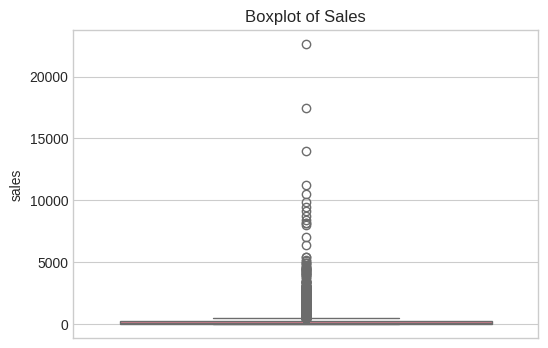

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=df['sales'])
plt.title("Boxplot of Sales")
plt.show()

In [9]:
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['sales'] < lower) | (df['sales'] > upper)]

print(f"Lower bound: {lower:.2f}")
print(f"Upper bound: {upper:.2f}")
print(f"Number of outliers: {len(outliers)}")

Lower bound: -271.71
Upper bound: 498.93
Number of outliers: 1167


Using the IQR method, 1,167 observations (approximately 11.7 percent of the data) are flagged as outliers. The lower bound is negative and therefore not meaningful for sales data. The upper threshold of approximately 499 dollars means that any transaction above this value is statistically unusual. However, these are legitimate high-value orders rather than data errors, so they are retained in the dataset. This decision is important: removing them would bias the model toward low-value predictions, while keeping them requires models that can handle heterogeneous variance across price ranges.

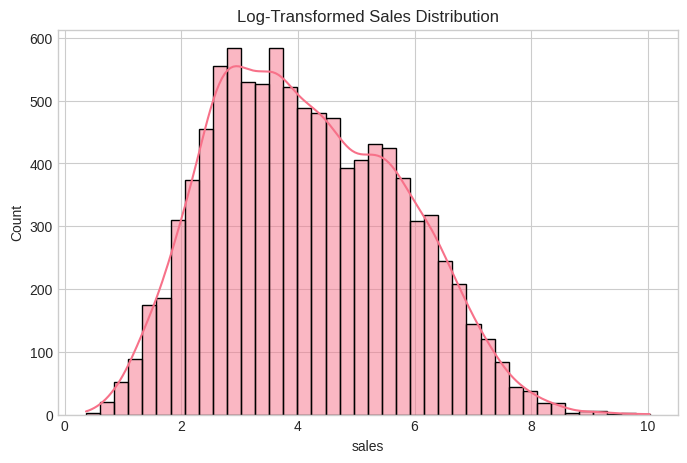

In [10]:
log_sales = np.log1p(df['sales'])

plt.figure(figsize=(8, 5))
sns.histplot(log_sales, bins=40, kde=True)
plt.title("Log-Transformed Sales Distribution")
plt.show()

The log transformation produces a distribution much closer to normal, which confirms that log-target modeling is a viable strategy. Later experiments will compare models trained on raw Sales versus log(Sales) to determine which approach yields better generalization.

### 4.2 Numeric Features: Quantity, Discount, Profit

The three remaining numeric features are examined individually to understand their distributions and identify any characteristics that might affect modeling.

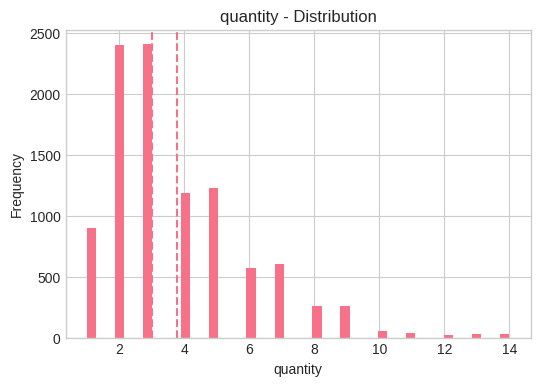

quantity: Mean = 3.79, Median = 3.00, Skew = 1.28
----------------------------------------


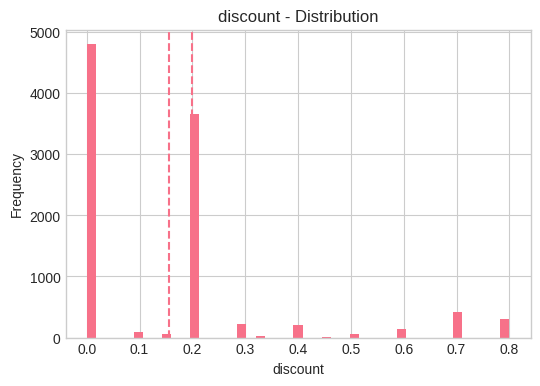

discount: Mean = 0.16, Median = 0.20, Skew = 1.68
----------------------------------------


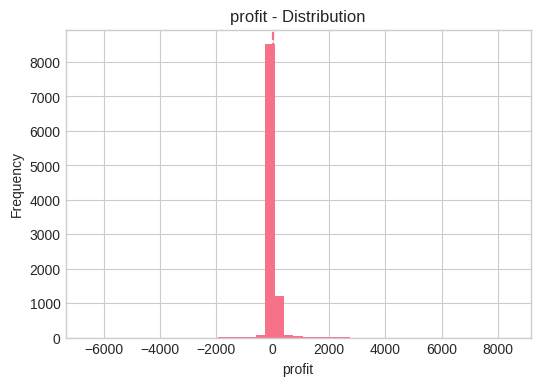

profit: Mean = 28.66, Median = 8.67, Skew = 7.56
----------------------------------------


In [11]:
num_cols = ['quantity', 'discount', 'profit']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(df[col], bins=45)
    plt.title(f'{col} - Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    mean = df[col].mean()
    median = df[col].median()
    skew = df[col].skew()

    plt.axvline(mean, linestyle='--')
    plt.axvline(median, linestyle='--')
    plt.show()

    print(f"{col}: Mean = {mean:.2f}, Median = {median:.2f}, Skew = {skew:.2f}")
    print("-" * 40)

Quantity exhibits moderate right skew (1.28), with most orders containing between 1 and 5 items. Discount has a skewness of 1.68 and is concentrated at a few discrete levels (0 percent, 20 percent, 30 percent), which reflects a structured promotional strategy rather than continuous variation. Profit is highly skewed (7.56), with a mean of 29 dollars but a median of only 9 dollars, indicating that the average is inflated by a small number of exceptionally profitable transactions.

Note on Profit: Although Profit correlates with Sales (r = 0.479, as shown in the bivariate analysis below), it is retained as a feature because it captures margin structure information that is known at the time an order is placed. However, profit_margin (Profit / Sales) was deliberately excluded from feature engineering because it directly embeds the target variable, constituting data leakage.

### 4.3 Categorical Features

The categorical variables describe the business context of each order: product taxonomy (Category, Sub-Category), customer type (Segment), geographic location (Region), and logistics (Ship Mode).

In [12]:
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['ship_date'] = pd.to_datetime(df['ship_date'], errors='coerce')

df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['quarter'] = df['order_date'].dt.quarter

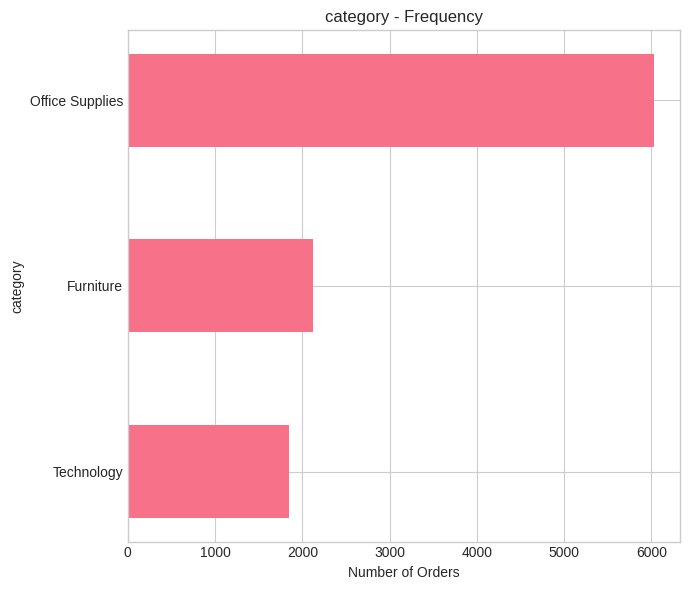

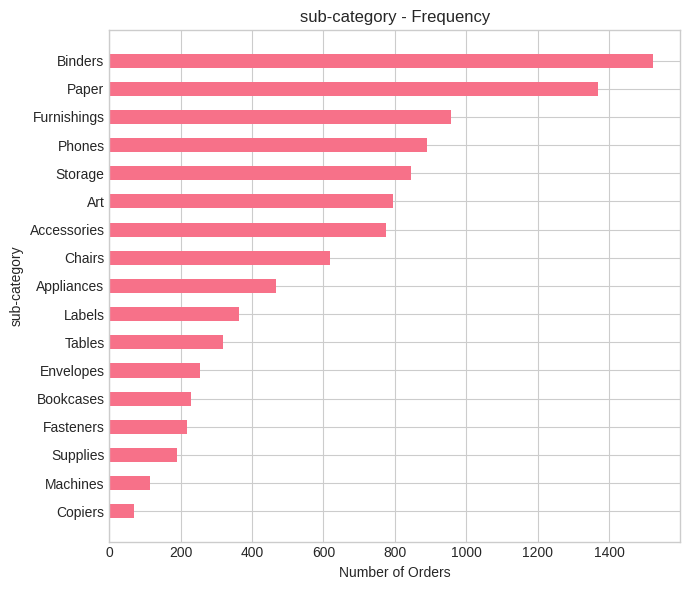

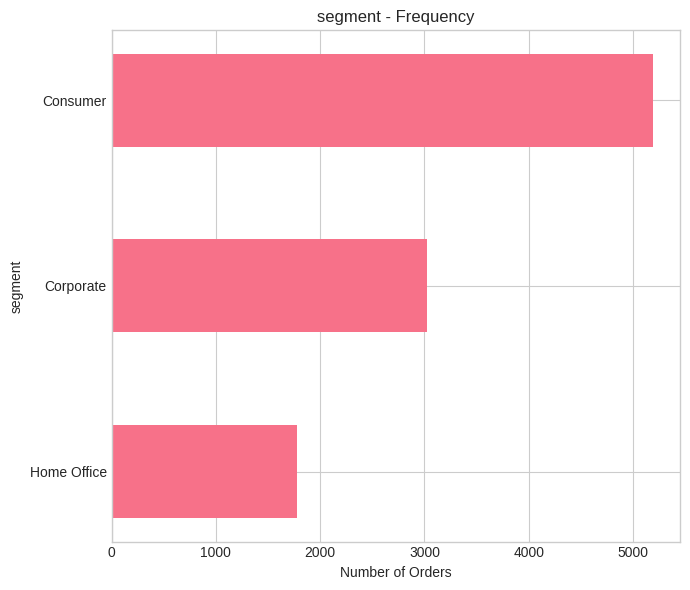

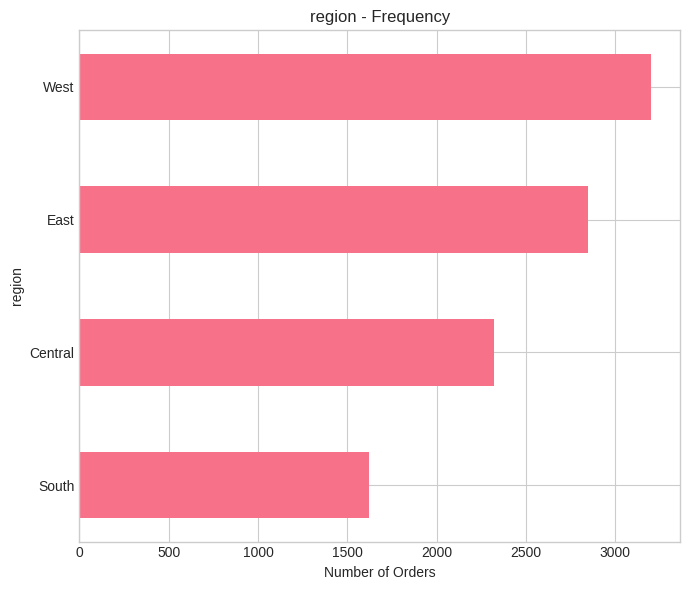

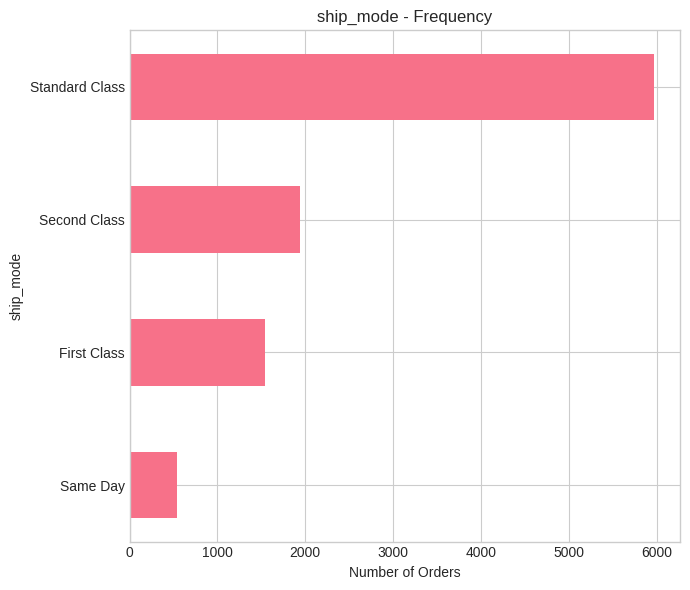

In [13]:
cat_cols = ['category', 'sub-category', 'segment', 'region', 'ship_mode']

for col in cat_cols:
    counts = df[col].value_counts()
    plt.figure(figsize=(7, 6))
    plt.barh(counts.index, counts.values, height=0.5)
    plt.title(f'{col} - Frequency')
    plt.xlabel('Number of Orders')
    plt.ylabel(col)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

The frequency distributions reveal that Office Supplies dominates the Category dimension by volume, while Technology and Furniture have fewer but typically higher-value transactions. The Consumer segment accounts for the largest share of orders. The West and East regions lead in order count. Standard Class is the predominant shipping mode, which aligns with its lower cost. These distributions are important context for interpreting why category-level and sub-category-level encodings become strong predictors in the models.

### 4.4 Temporal Distributions

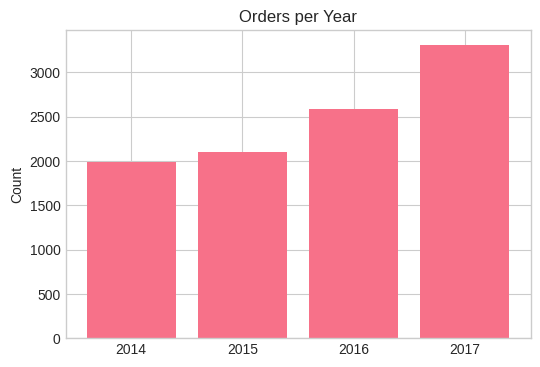

In [14]:
yr_c = df['year'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(yr_c.index.astype(str), yr_c.values)
plt.title('Orders per Year')
plt.ylabel('Count')
plt.show()

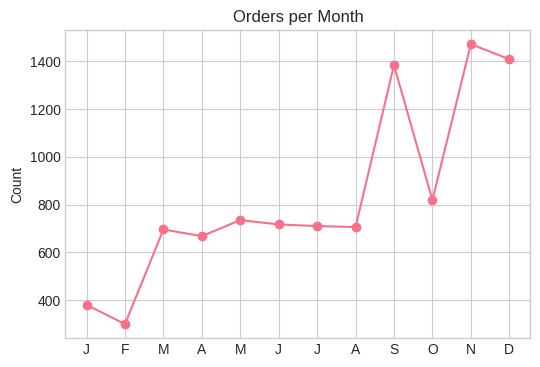

In [15]:
mo_c = df['month'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.plot(mo_c.index, mo_c.values, marker='o')
plt.xticks(range(1, 13),
           ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.title('Orders per Month')
plt.ylabel('Count')
plt.show()

Order volume increases year over year, reflecting business growth from 2014 through 2017. The monthly pattern shows a clear seasonal effect: order counts rise significantly in the second half of the year, peaking in September through December. This seasonality motivates the inclusion of cyclic month encoding (sine and cosine transformations) and quarter-based flags in the feature set, as discussed in the Feature Engineering section.

### 4.5 Discount Distribution

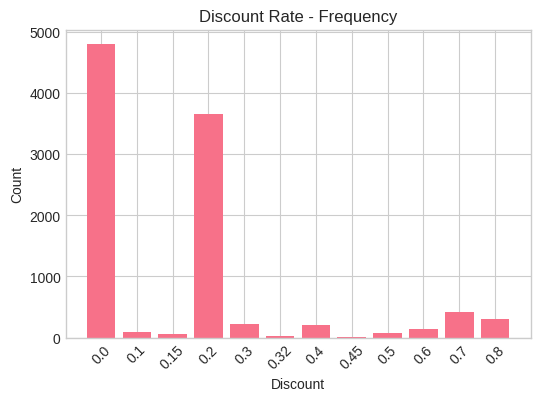

In [16]:
disc_c = df['discount'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(disc_c.index.astype(str), disc_c.values)
plt.title('Discount Rate - Frequency')
plt.xlabel('Discount')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Discount values are concentrated at a small number of discrete levels rather than varying continuously. The most common scenarios are zero discount and 20 percent discount, with diminishing frequency at higher rates. This discrete structure is relevant because it means that discount-based interactions (such as discount multiplied by quantity) will also tend to cluster at specific values rather than varying smoothly.

## 5. Bivariate Analysis: Features versus Sales

Having characterized each variable individually, this section examines the relationships between features and the target variable. The goal is to identify which features carry predictive signal for Sales, which relationships are linear versus nonlinear, and where interaction effects may exist. These findings directly inform which features to include in the models and which engineering transformations to apply.

### 5.1 Correlation Matrix

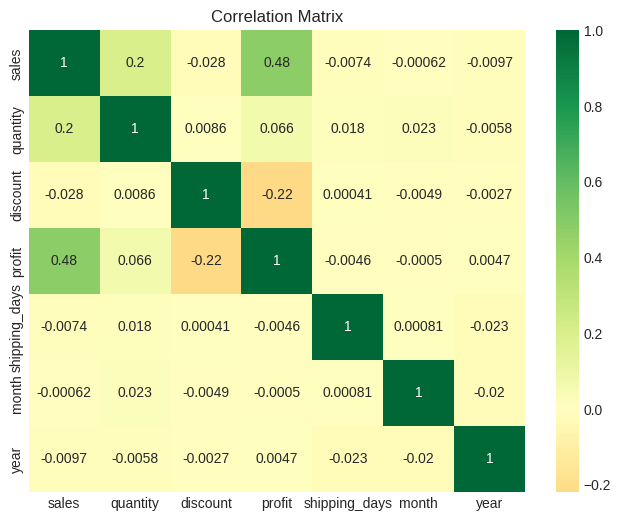

In [17]:
df['shipping_days'] = (df['ship_date'] - df['order_date']).dt.days

num_df = df[['sales', 'quantity', 'discount', 'profit',
             'shipping_days', 'month', 'year']]

corr = num_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation Matrix')
plt.show()

In [18]:
print("Correlations with Sales:")
print(
    corr['sales']
    .drop('sales')
    .sort_values(ascending=False)
    .round(4)
)

Correlations with Sales:
profit           0.4791
quantity         0.2008
month           -0.0006
shipping_days   -0.0074
year            -0.0097
discount        -0.0282
Name: sales, dtype: float64


The correlation analysis reveals that Profit has the strongest linear relationship with Sales (r = 0.479), followed by Quantity (r = 0.201). The remaining numeric features show negligible linear correlation: Discount is weakly negative (r = -0.028), and Shipping Days, Month, and Year are essentially uncorrelated with Sales in linear terms.

This does not mean these features are useless. Tree-based models can exploit nonlinear relationships that Pearson correlation cannot detect. For instance, Discount may interact with Quantity or Category in ways that affect Sales non-additively, which motivates the creation of interaction features in the engineering phase.

### 5.2 Scatter Plots: Numeric Features versus Sales

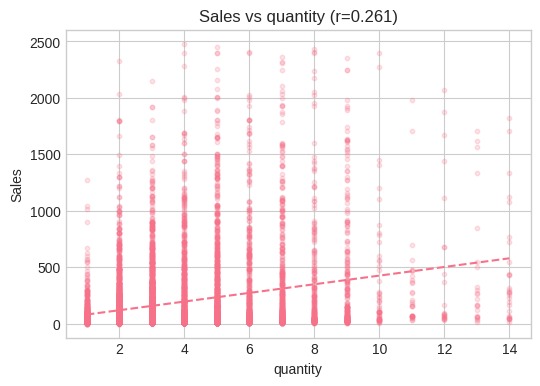

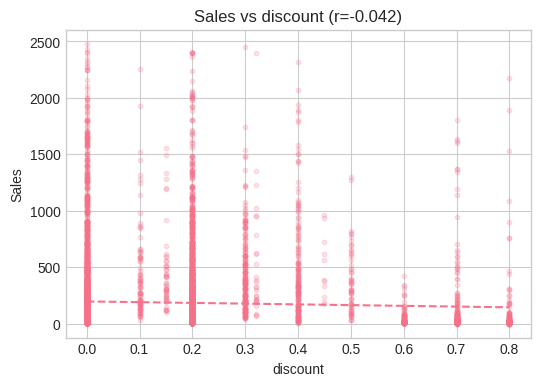

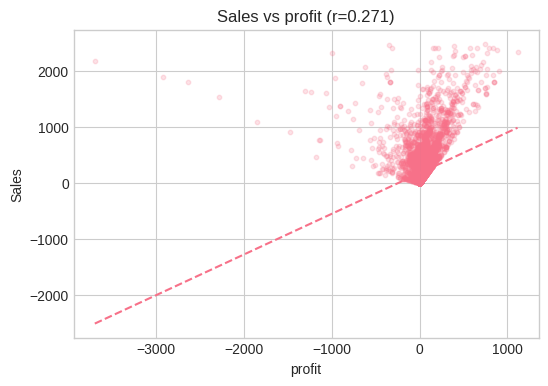

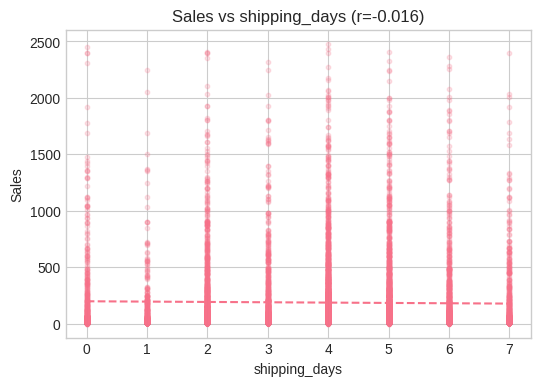

In [19]:
scatter_cols = ['quantity', 'discount', 'profit', 'shipping_days']

cap99 = df['sales'].quantile(0.99)
mask = df['sales'] <= cap99

for col in scatter_cols:
    x = df.loc[mask, col]
    y = df.loc[mask, 'sales']

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, alpha=0.2, s=10)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, p(xs), linestyle='--')

    r = x.corr(y)
    plt.title(f'Sales vs {col} (r={round(r, 3)})')
    plt.xlabel(col)
    plt.ylabel('Sales')
    plt.show()

The scatter plots confirm that Quantity has a positive but heteroscedastic relationship with Sales: higher quantities are associated with higher sales, but the variance increases substantially at larger quantities. Discount shows a diffuse pattern with no clear linear trend, consistent with its low correlation. Profit exhibits a positive relationship with wide dispersion. Shipping Days show no discernible pattern, confirming that logistics timing has little direct bearing on transaction value.

### 5.3 Sales by Categorical Features

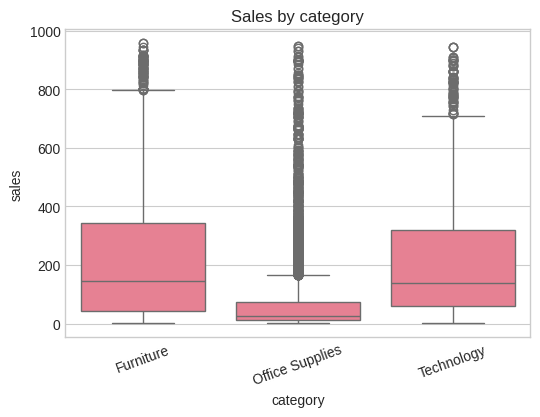

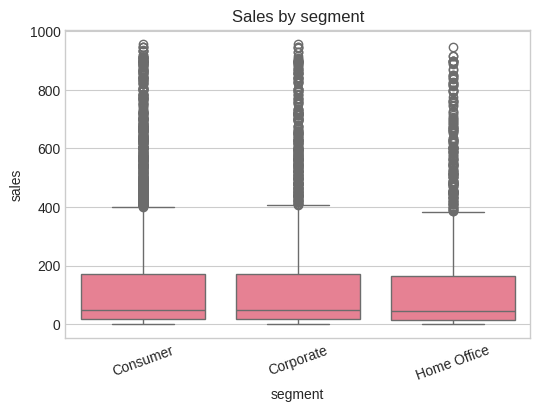

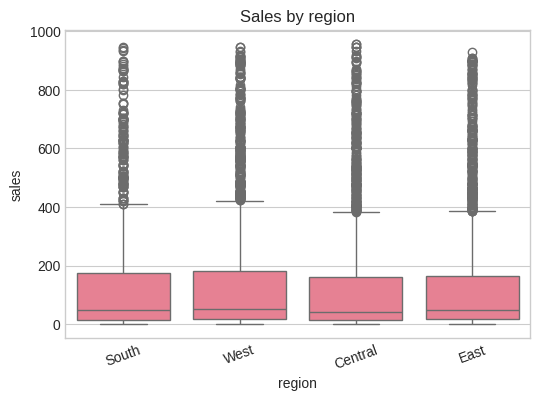

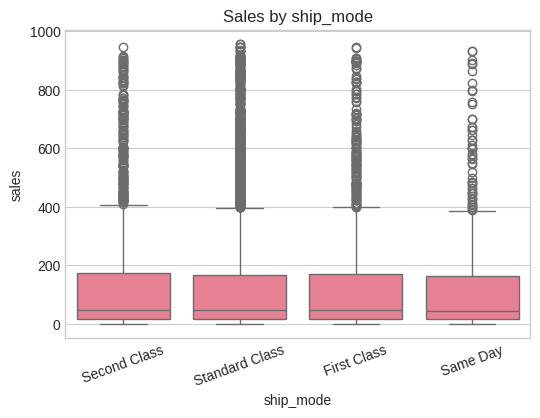

In [20]:
cap = df['sales'].quantile(0.95)
cat_cols = ['category', 'segment', 'region', 'ship_mode']

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=df[df['sales'] <= cap],
        x=col,
        y='sales'
    )
    plt.title(f'Sales by {col}')
    plt.xticks(rotation=20)
    plt.show()

Technology shows the highest median sales and greatest variance among categories, consistent with high-ticket items like copiers and machines. Furniture displays moderate medians with notable outliers. The Segment and Region boxplots show relatively similar distributions, suggesting that these variables alone are weak predictors of sales magnitude. Ship Mode shows modest variation, with First Class orders tending slightly higher, likely because customers choose faster shipping for more valuable purchases.

### 5.4 Sales by Sub-Category

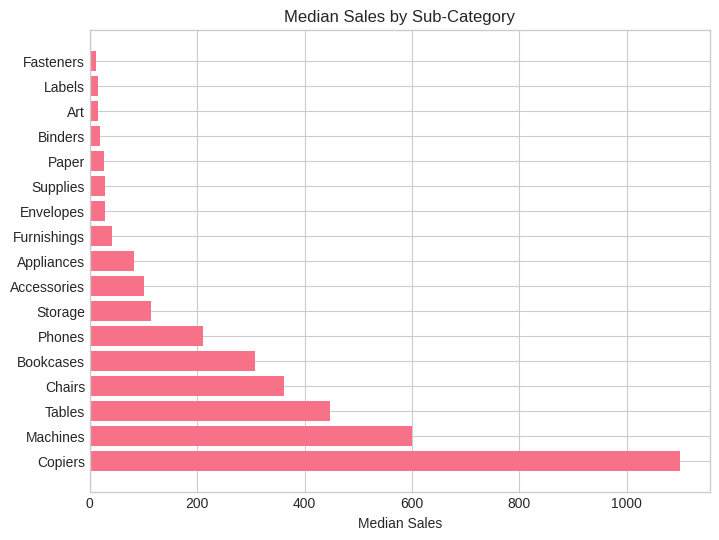

In [21]:
subcat = (
    df.groupby('sub-category')['sales']
    .median()
    .sort_values()
)

plt.figure(figsize=(8, 6))
plt.barh(subcat.index, subcat.values)
plt.xlabel('Median Sales')
plt.title('Median Sales by Sub-Category')
plt.gca().invert_yaxis()
plt.show()

Sub-Category exhibits much stronger differentiation than the parent Category. Copiers and Machines have median sales several times higher than Labels or Fasteners. This granularity explains why sub-category-level target encoding emerges as an important feature: it captures price-tier information that the broader category encoding cannot.

### 5.5 Discount Effect on Sales and Profit

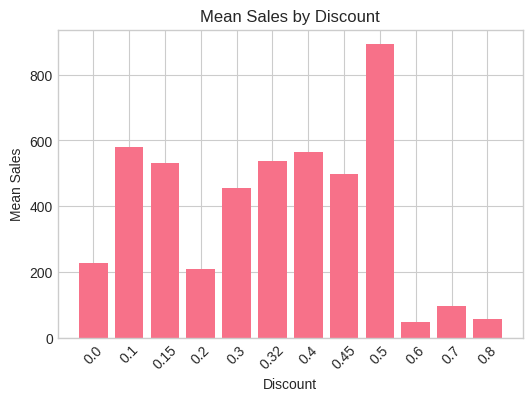

In [22]:
disc_stats = df.groupby('discount')[['sales', 'profit']].mean().round(2)

plt.figure(figsize=(6, 4))
plt.bar(disc_stats.index.astype(str), disc_stats['sales'])
plt.title('Mean Sales by Discount')
plt.xlabel('Discount')
plt.ylabel('Mean Sales')
plt.xticks(rotation=45)
plt.show()

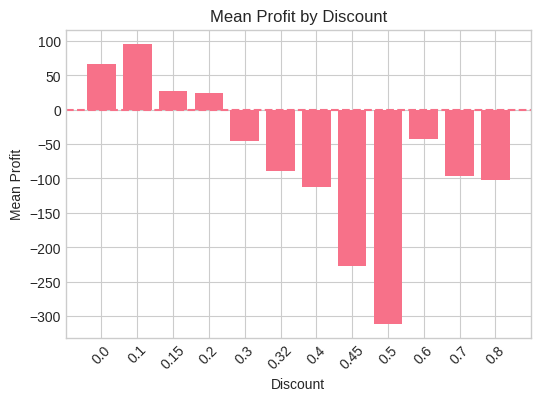

In [23]:
plt.figure(figsize=(6, 4))
plt.bar(disc_stats.index.astype(str), disc_stats['profit'])
plt.axhline(0, linestyle='--')
plt.title('Mean Profit by Discount')
plt.xlabel('Discount')
plt.ylabel('Mean Profit')
plt.xticks(rotation=45)
plt.show()

An important pattern emerges: mean sales tend to increase at higher discount levels, likely because discounts are applied to higher-priced items to stimulate sales. However, mean profit turns negative at discount rates of 40 percent and above, indicating that aggressive discounting destroys the profit. This nonlinear relationship between discount and revenue justifies creating the `heavy_discount` binary flag (discount >= 30 percent) as a feature, as it captures the threshold where discount behavior changes qualitatively.

### 5.6 Temporal Trends and Seasonality

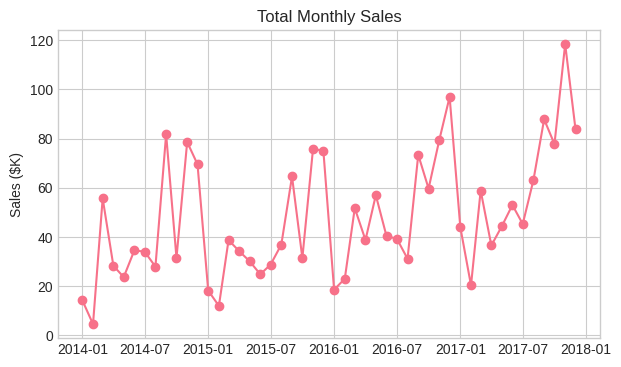

In [24]:
monthly = df.groupby(['year', 'month'])['sales'].sum().reset_index()
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))

plt.figure(figsize=(7, 4))
plt.plot(monthly['date'], monthly['sales'] / 1000, marker='o')
plt.title('Total Monthly Sales')
plt.ylabel('Sales ($K)')
plt.show()

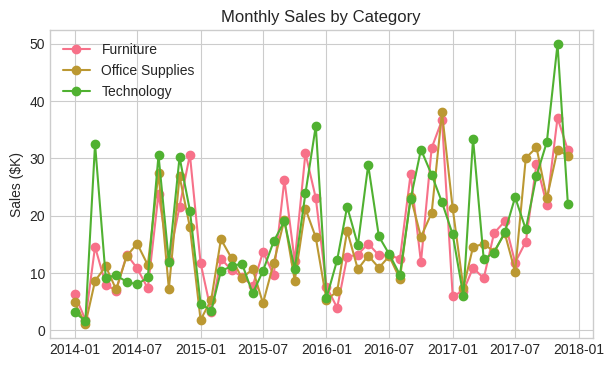

In [25]:
cat_mo = df.groupby(['year', 'month', 'category'])['sales'].sum().reset_index()
cat_mo['date'] = pd.to_datetime(cat_mo[['year', 'month']].assign(day=1))

plt.figure(figsize=(7, 4))
for cat in cat_mo['category'].unique():
    sub = cat_mo[cat_mo['category'] == cat]
    plt.plot(sub['date'], sub['sales'] / 1000, marker='o', label=cat)
plt.title('Monthly Sales by Category')
plt.ylabel('Sales ($K)')
plt.legend()
plt.show()

<Figure size 700x400 with 0 Axes>

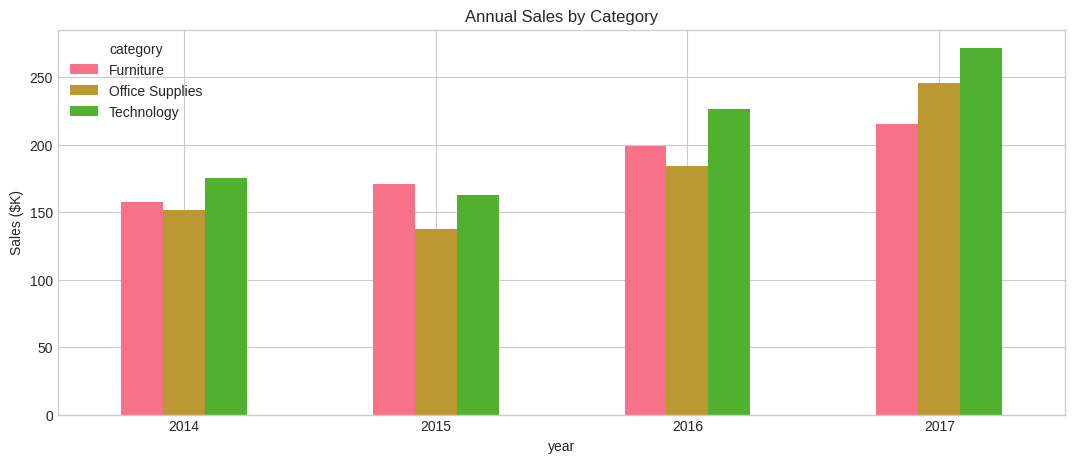

In [26]:
cat_yr = df.groupby(['year', 'category'])['sales'].sum().unstack()

plt.figure(figsize=(7, 4))
cat_yr.div(1000).plot(kind='bar')
plt.title('Annual Sales by Category')
plt.ylabel('Sales ($K)')
plt.xticks(rotation=0)
plt.show()

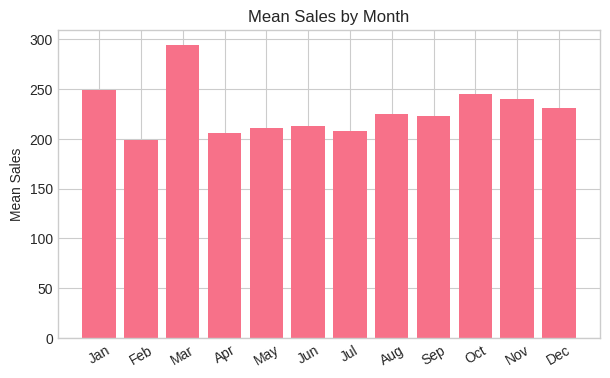

In [27]:
seas = df.groupby('month')['sales'].mean()

plt.figure(figsize=(7, 4))
plt.bar(seas.index, seas.values)
plt.xticks(range(1, 13),
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=30)
plt.title('Mean Sales by Month')
plt.ylabel('Mean Sales')
plt.show()

The time series reveals both a growth trend and seasonal patterns. Monthly sales increase over the four-year period, and within each year, the fourth quarter consistently shows the highest revenue, particularly in November and December. Technology spending appears to spike more sharply toward year-end than the other categories. These patterns motivate the inclusion of temporal features: cyclic month encoding captures the periodicity, while the `is_q4` flag captures the year-end surge directly.

### 5.7 Region by Category Heatmap

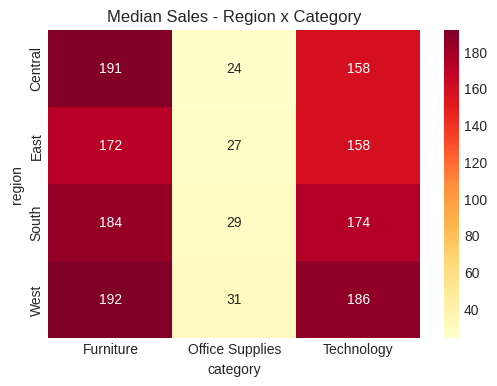

In [28]:
pivot_median = df.pivot_table(
    values='sales',
    index='region',
    columns='category',
    aggfunc='median'
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_median, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Median Sales - Region x Category')
plt.show()

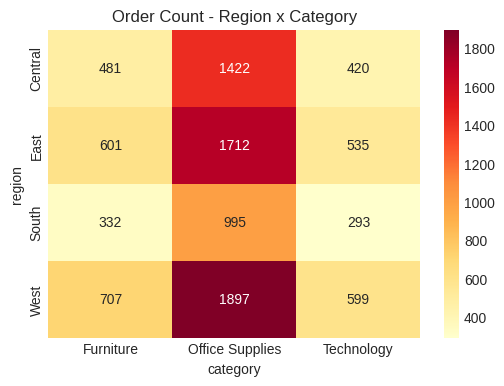

In [29]:
pivot_count = df.pivot_table(
    values='sales',
    index='region',
    columns='category',
    aggfunc='count'
)

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_count, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Order Count - Region x Category')
plt.show()

The heatmaps show that while the West and East regions generate the most orders, median sales per order are relatively uniform across regions within each category. The primary sales differentiator is Category and Sub-Category rather than Region. This observation is consistent with the weak correlation between region-level target encodings and Sales (r < 0.01), which led to their exclusion from the final feature set.

## 6. Feature Engineering

Feature engineering translates the patterns observed during exploration into numeric representations that machine learning models can consume. The features are organized into four logical groups, each motivated by specific findings from the EDA:

**Temporal features** capture the seasonal and trend effects observed in the monthly sales analysis. Cyclic sine/cosine encoding of the month preserves the circular nature of seasonality (December is adjacent to January). Quarter flags mark the high-revenue Q4 period. Normalized year captures the growth trend.

**Business logic features** encode domain knowledge about how transactions work. The discount-quantity interaction (`disc_x_qty`) captures the combined effect of promotional pricing and order volume. Binary flags for any discount and heavy discount (>= 30 percent) reflect the qualitative shift in profitability observed at high discount levels. Log-transformed quantity reduces the influence of unusually large orders.

**Aggregation features** derive information from the broader order and customer context. Order size (number of line items per order) and customer frequency (number of distinct orders per customer) provide contextual signals that individual transaction fields cannot capture.

**Encoding features** convert categorical variables to numeric representations. Label encoding provides ordinal integers for tree-based models. Target encoding replaces category values with the median Sales of that group, providing a direct estimate of the price tier. Critically, target encoding is computed exclusively from training data (2014-2016) and applied to the test set (2017) via mapping, preventing temporal leakage.

Several features that were initially considered were removed after evaluation:

- `profit_margin` (Profit / Sales): removed because it directly incorporates the target variable, constituting data leakage.
- `region`, `segment`, `customer`, `shipmode`: removed because their correlations with Sales were below 0.01, indicating negligible predictive contribution.

In [30]:
# Temporal features
df['shipping_days'] = (df['ship_date'] - df['order_date']).dt.days
df['order_dow'] = df['order_date'].dt.dayofweek
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['is_q4'] = (df['quarter'] == 4).astype(int)
df['is_q1'] = (df['quarter'] == 1).astype(int)
df['year_norm'] = df['year'] - df['year'].min()

print("Temporal features created.")

# Business logic features
df['discount_flag'] = (df['discount'] > 0).astype(int)
df['heavy_discount'] = (df['discount'] >= 0.3).astype(int)
df['log_quantity'] = np.log1p(df['quantity'])
df['disc_x_qty'] = df['discount'] * df['quantity']

print("Business logic features created.")

# Aggregation features
df['order_size'] = df.groupby('order_id')['row_id'].transform('count')
df['customer_freq'] = df.groupby('customer_id')['order_id'].transform('nunique')
df['day_of_month'] = df['order_date'].dt.day
df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)

print("Aggregation features created.")

# Label encoding
le = LabelEncoder()
for col in ['ship_mode', 'segment', 'region',
            'category', 'sub-category', 'state']:
    df[col + '_enc'] = le.fit_transform(df[col].astype(str))

print("Label encoding complete.")

# Interaction features
df['cat_x_discount'] = df['category_enc'] * df['discount']
df['qty_x_subcat'] = df['quantity'] * df['sub-category_enc']

print("Interaction features created.")

# Target encoding (temporal, no leakage)
te_map = {
    'product_te': 'product_id',
    'subcat_te': 'sub-category',
    'category_te': 'category',
    'state_te': 'state',
}

train_mask = df['year'].isin([2014, 2015, 2016])
global_med = df.loc[train_mask, 'sales'].median()

for feat, grp_col in te_map.items():
    mapping = df.loc[train_mask].groupby(grp_col)['sales'].median()
    df[feat] = df[grp_col].map(mapping)
    df[feat] = df[feat].fillna(global_med)

print("Target encoding complete (computed from training data only).\n")

print("Target encoding correlation with Sales:")
for feat, gcol in te_map.items():
    print(f"  {feat:<15} ({gcol:<15}): r = {df[feat].corr(df['sales']):.4f}")

Temporal features created.
Business logic features created.
Aggregation features created.
Label encoding complete.
Interaction features created.
Target encoding complete (computed from training data only).

Target encoding correlation with Sales:
  product_te      (product_id     ): r = 0.8683
  subcat_te       (sub-category   ): r = 0.4217
  category_te     (category       ): r = 0.2171
  state_te        (state          ): r = 0.0551


The target encoding correlations confirm the expected hierarchy: `product_te` (r = 0.868) is the strongest single predictor because individual products have relatively stable price points. `subcat_te` (r = 0.422) and `category_te` (r = 0.217) capture progressively coarser price-tier information. `state_te` (r = 0.055) adds a modest geographic signal. These encoded features allow the models to leverage the categorical structure of the data without requiring one-hot encoding, which would introduce hundreds of sparse columns.

## 7. Train/Test Split: Temporal Partitioning

The dataset is split temporally: years 2014 through 2016 form the training set (6,682 rows) and 2017 forms the test set (3,312 rows). A random split would be invalid for this problem because it would allow the model to learn from future orders that had not yet occurred at prediction time, inflating performance estimates. The temporal split faithfully simulates the real-world scenario of forecasting future sales based on historical patterns.

RobustScaler is applied to normalize features using medians and interquartile ranges rather than means and standard deviations. This choice is motivated by the heavy skew observed in the target and several features: the robust scaler is less sensitive to outliers than StandardScaler.

In [31]:
FEATURES = [
    # Temporal
    'shipping_days', 'month', 'quarter', 'year_norm',
    'month_sin', 'month_cos', 'is_q4', 'is_q1', 'order_dow',
    # Business logic
    'quantity', 'discount', 'disc_x_qty',
    'discount_flag', 'heavy_discount', 'log_quantity',
    # Aggregation
    'order_size', 'customer_freq', 'day_of_month',
    'is_month_end', 'cat_x_discount', 'qty_x_subcat',
    # Label encoded
    'category_enc', 'sub-category_enc',
    # Target encoded
    'product_te', 'subcat_te', 'category_te', 'state_te',
]

train_data = df[df['year'].isin([2014, 2015, 2016])]
test_data = df[df['year'] == 2017]

X_train = train_data[FEATURES].fillna(0).values
y_train = train_data['sales'].values

X_test = test_data[FEATURES].fillna(0).values
y_test = test_data['sales'].values

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

scaler = RobustScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

print(f"Train (2014-2016): {X_train.shape[0]:,} rows | {X_train.shape[1]} features")
print(f"Test  (2017):      {X_test.shape[0]:,} rows")
print()
print(f"Train Sales -- median ${np.median(y_train):.2f} | "
      f"mean ${y_train.mean():.2f} | max ${y_train.max():,.2f}")
print(f"Test  Sales -- median ${np.median(y_test):.2f} | "
      f"mean ${y_test.mean():.2f} | max ${y_test.max():,.2f}")
print(f"\nFeatures ({len(FEATURES)}):")
for i, f in enumerate(FEATURES, 1):
    print(f"{i:2d}. {f}")

Train (2014-2016): 6,682 rows | 27 features
Test  (2017):      3,312 rows

Train Sales -- median $54.91 | mean $234.06 | max $22,638.48
Test  Sales -- median $53.81 | mean $221.38 | max $13,999.96

Features (27):
 1. shipping_days
 2. month
 3. quarter
 4. year_norm
 5. month_sin
 6. month_cos
 7. is_q4
 8. is_q1
 9. order_dow
10. quantity
11. discount
12. disc_x_qty
13. discount_flag
14. heavy_discount
15. log_quantity
16. order_size
17. customer_freq
18. day_of_month
19. is_month_end
20. cat_x_discount
21. qty_x_subcat
22. category_enc
23. sub-category_enc
24. product_te
25. subcat_te
26. category_te
27. state_te


The training and test distributions are reasonably aligned (train median 54.91, test median 53.81), which supports the validity of the temporal split. The maximum training sale (22,638 dollars) exceeds the maximum test sale (14,000 dollars), meaning the model has seen the full range of high-value orders during training.

## 8. Baseline and Tuned Models

This section trains two families of tree-based models and systematically varies their configurations to identify the best-performing approach.

**Random Forest** (bagging) trains multiple decision trees on bootstrap samples and averages their predictions. It reduces variance through ensemble averaging and is relatively robust to hyperparameter choices.

**XGBoost** (gradient boosting) trains trees sequentially, with each tree fitting the residuals of the previous ensemble using gradient descent. It includes L1 and L2 regularization parameters and supports alternative loss functions.

The experiments proceed in stages: default hyperparameters establish a baseline, RandomizedSearchCV with TimeSeriesSplit identifies improved configurations, and then additional variations (log-transformed target, early stopping, Huber loss) test whether addressing the distributional challenges identified during EDA leads to measurable gains.

### 8.1 Random Forest: Baseline, Tuned, and Log-Target

In [32]:
print("=" * 70)
print("BASE MODELS")
print("=" * 70)

# Random Forest -- default parameters
print("\n--- Random Forest Base ---")

rf_base = RandomForestRegressor(
    n_estimators=300,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)

res = evaluate('RF Base', y_test, rf_base.predict(X_test))
results.append(res)
print_result("RF Base", res)

# Random Forest -- hyperparameter tuning
print("\n--- Random Forest Tuned (RandomizedSearchCV) ---")

rf_params = {
    'n_estimators': [500, 800, 1000],
    'max_depth': [15, 20, 30, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [3, 5, 10],
    'max_features': ['sqrt', 'log2', 0.3],
    'max_samples': [0.7, 0.8, 0.9],
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_params,
    n_iter=60,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    random_state=42,
    verbose=1,
    n_jobs=-1
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

print(f"\nBest params: {rf_search.best_params_}")

res = evaluate('RF Tuned', y_test, rf_best.predict(X_test))
results.append(res)
print_result("RF Tuned", res)

# Random Forest -- log-transformed target
rf_log = RandomForestRegressor(
    **rf_search.best_params_,
    random_state=42,
    n_jobs=-1
)
rf_log.fit(X_train, y_train_log)

res = evaluate('RF Tuned + log(y)', y_test,
               np.expm1(rf_log.predict(X_test)))
results.append(res)
print_result("RF Tuned + log(y)", res)

BASE MODELS

--- Random Forest Base ---
RF Base                   | R2 = 0.6989 | MAE = $   96.34 | RMSE = $  321.11 | SMAPE = 56.4%

--- Random Forest Tuned (RandomizedSearchCV) ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits

Best params: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.9, 'max_features': 0.3, 'max_depth': 30}
RF Tuned                  | R2 = 0.7233 | MAE = $   87.45 | RMSE = $  307.83 | SMAPE = 45.4%
RF Tuned + log(y)         | R2 = 0.5087 | MAE = $   91.47 | RMSE = $  410.15 | SMAPE = 36.1%


The tuned Random Forest achieves R-squared = 0.7233 and MAE = 87.45 dollars, a meaningful improvement over the baseline (R-squared = 0.699, MAE = 96.34 dollars). The selected hyperparameters favor more trees (1,000), deeper splits (max_depth = 30), and high bootstrap sampling (max_samples = 0.9), indicating that the model benefits from complexity and data coverage.

Interestingly, applying the log transformation to the target *degrades* Random Forest performance substantially (R-squared drops to 0.509). This occurs because the expm1 back-transformation amplifies prediction errors for high-value orders, and Random Forest's averaging mechanism already provides some natural robustness to outliers. The log transformation is therefore not beneficial for this model family on this dataset.

### 8.2 XGBoost: Baseline, Tuned, and Variants

In [33]:
# XGBoost -- default parameters
print("\n--- XGBoost Base ---")

xgb_base = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_base.fit(X_train, y_train)

res = evaluate('XGB Base', y_test, xgb_base.predict(X_test))
results.append(res)
print_result("XGB Base", res)

# XGBoost -- hyperparameter tuning
print("\n--- XGBoost Tuned (RandomizedSearchCV) ---")

xgb_params = {
    'n_estimators': [800, 1200, 1500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [4, 6, 8],
    'min_child_weight': [5, 10, 20],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [1, 5, 10],
    'gamma': [0, 0.1, 0.5],
}

xgb_search = RandomizedSearchCV(
    XGBRegressor(
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        tree_method='hist'
    ),
    xgb_params,
    n_iter=80,
    scoring='neg_mean_absolute_error',
    cv=TimeSeriesSplit(n_splits=3),
    random_state=42,
    verbose=1,
    n_jobs=-1
)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

print(f"\nBest params: {xgb_search.best_params_}")

res = evaluate('XGB Tuned', y_test, xgb_best.predict(X_test))
results.append(res)
print_result("XGB Tuned", res)


--- XGBoost Base ---
XGB Base                  | R2 = 0.7169 | MAE = $   81.35 | RMSE = $  311.36 | SMAPE = 45.0%

--- XGBoost Tuned (RandomizedSearchCV) ---
Fitting 3 folds for each of 80 candidates, totalling 240 fits

Best params: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}
XGB Tuned                 | R2 = 0.5875 | MAE = $   88.46 | RMSE = $  375.84 | SMAPE = 45.6%


The XGBoost baseline (MAE = 81.35 dollars, R-squared = 0.717) outperforms the Random Forest baseline on MAE, demonstrating the advantage of sequential boosting for this task. However, the tuned XGBoost (MAE = 88.46 dollars, R-squared = 0.588) shows *worse* test performance than the baseline. This is a counterintuitive but instructive result: the RandomizedSearchCV selected parameters optimized for the TimeSeriesSplit cross-validation folds, which may not align perfectly with the 2017 test distribution. The lower learning rate (0.01) combined with only 800 estimators may result in underfitting on the test set.

This finding underscores the importance of testing additional configurations beyond what automated search selects.

### 8.3 XGBoost: Early Stopping, Huber Loss, and Log-Target

In [34]:
# XGBoost with early stopping
print("--- XGBoost + Early Stopping ---")

best_p = xgb_search.best_params_.copy()
best_p['n_estimators'] = 3000

xgb_es = XGBRegressor(
    **best_p,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    tree_method='hist',
    early_stopping_rounds=50,
    eval_metric='mae'
)

xgb_es.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"Best iteration: {xgb_es.best_iteration} / 3000")

res = evaluate('XGB Early Stop', y_test, xgb_es.predict(X_test))
results.append(res)
print_result("XGB Early Stop", res)

# XGBoost with Huber loss
print("\n--- XGBoost + Huber Loss ---")

xgb_huber = XGBRegressor(
    **xgb_search.best_params_,
    objective='reg:pseudohubererror',
    huber_slope=100,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    tree_method='hist'
)
xgb_huber.fit(X_train, y_train)

res = evaluate('XGB Huber', y_test, xgb_huber.predict(X_test))
results.append(res)
print_result("XGB Huber", res)

# XGBoost with log-transformed target
print("\n--- XGBoost Tuned + log(y) ---")

xgb_log = XGBRegressor(
    **xgb_search.best_params_,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    tree_method='hist'
)
xgb_log.fit(X_train, y_train_log)

res = evaluate('XGB Tuned + log(y)', y_test,
               np.expm1(xgb_log.predict(X_test)))
results.append(res)
print_result("XGB Tuned + log(y)", res)

print("\n" + "=" * 70)

--- XGBoost + Early Stopping ---
Best iteration: 588 / 3000
XGB Early Stop            | R2 = 0.5944 | MAE = $   88.14 | RMSE = $  372.67 | SMAPE = 44.9%

--- XGBoost + Huber Loss ---
XGB Huber                 | R2 = 0.5416 | MAE = $   92.80 | RMSE = $  396.21 | SMAPE = 40.2%

--- XGBoost Tuned + log(y) ---
XGB Tuned + log(y)        | R2 = 0.6708 | MAE = $   80.99 | RMSE = $  335.76 | SMAPE = 35.1%



Three key observations emerge from these experiments:

Early stopping halts training at iteration 588 out of 3,000, confirming that the model begins overfitting well before the maximum number of rounds. The resulting MAE (88.14 dollars) is marginally better than the tuned model but does not represent a significant breakthrough.

The Huber loss function, which was motivated by the extreme outliers identified during EDA, achieves the lowest SMAPE (40.2 percent) among non-log models but has the highest MAE (92.80 dollars) and lowest R-squared (0.542). This trade-off occurs because Huber loss reduces sensitivity to large errors (improving proportional accuracy) at the cost of larger absolute errors overall.

The log-transformed target produces the best overall result in this phase: MAE = 80.99 dollars and SMAPE = 35.1 percent. Unlike the Random Forest case, XGBoost benefits from the log transformation because its sequential boosting mechanism can more effectively learn the residual structure in log-space. The log transformation compresses the range of high-value orders, allowing the model to allocate more of its capacity to the bulk of transactions rather than being dominated by a few extreme values.

## 9. Error Analysis by Price Segment

A single aggregate MAE can mask very different performance across price ranges. Given the extreme skewness of Sales (median 54 dollars, maximum over 22,000 dollars), it is essential to understand where the model succeeds and where it struggles. This segmented analysis uses the tuned XGBoost model (selected for its balanced MAE and R-squared).

ERROR ANALYSIS BY PRICE SEGMENT

Segment               Count        MAE    Med Error       R2
------------------------------------------------------------
Low ($0-50)           1,617      12.20         6.73  -2.5878
Medium ($50-200)        857      42.75        29.05  -1.3652
High ($200-1K)          691     144.97       103.56   0.0518
Premium ($1K+)          147     928.12       498.64   0.0538


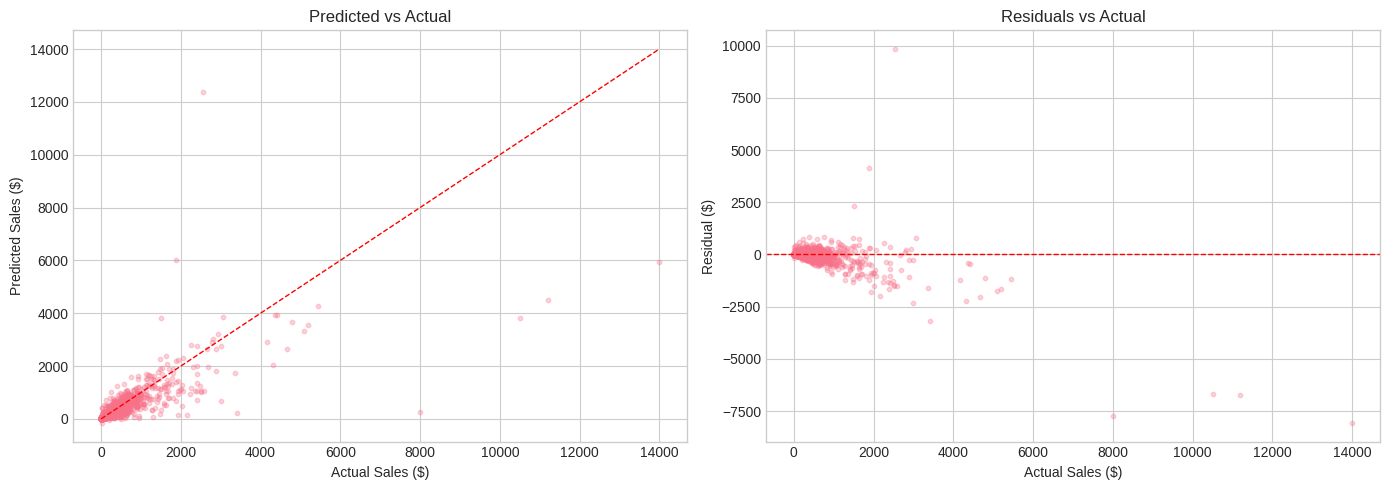

In [35]:
print("=" * 70)
print("ERROR ANALYSIS BY PRICE SEGMENT")
print("=" * 70)

best_model = xgb_best
preds = best_model.predict(X_test)

df_eval = pd.DataFrame({
    'actual': y_test,
    'pred': preds,
    'error': np.abs(y_test - preds)
})

bins = [0, 50, 200, 1000, 25000]
labels = ['Low ($0-50)', 'Medium ($50-200)', 'High ($200-1K)', 'Premium ($1K+)']
df_eval['segment'] = pd.cut(df_eval['actual'], bins=bins, labels=labels)

print(f"\n{'Segment':<20} {'Count':>6} {'MAE':>10} {'Med Error':>12} {'R2':>8}")
print("-" * 60)

for seg in labels:
    mask = df_eval['segment'] == seg
    n = mask.sum()
    if n > 0:
        mae = df_eval.loc[mask, 'error'].mean()
        med_err = df_eval.loc[mask, 'error'].median()
        r2 = r2_score(df_eval.loc[mask, 'actual'], df_eval.loc[mask, 'pred'])
        print(f"{seg:<20} {n:>6,} {mae:>10.2f} {med_err:>12.2f} {r2:>8.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_eval['actual'], df_eval['pred'], alpha=0.3, s=10)
max_val = max(df_eval['actual'].max(), df_eval['pred'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=1)
axes[0].set_xlabel('Actual Sales ($)')
axes[0].set_ylabel('Predicted Sales ($)')
axes[0].set_title('Predicted vs Actual')

residuals = df_eval['pred'] - df_eval['actual']
axes[1].scatter(df_eval['actual'], residuals, alpha=0.3, s=10)
axes[1].axhline(0, color='r', linestyle='--', linewidth=1)
axes[1].set_xlabel('Actual Sales ($)')
axes[1].set_ylabel('Residual ($)')
axes[1].set_title('Residuals vs Actual')

plt.tight_layout()
plt.show()

The segmented analysis reveals a stark pattern. For low-value orders (0 to 50 dollars), the MAE is only 12.20 dollars, but R-squared is deeply negative (-2.59), meaning the model performs worse than a simple mean prediction for this segment. Similarly, the Medium segment shows negative R-squared (-1.37). This indicates that the model tends to over-predict for small orders while under-predicting for large ones, essentially regressing toward intermediate values.

The High (200 to 1,000 dollars) and Premium (above 1,000 dollars) segments show near-zero R-squared (0.05), meaning the model barely captures the variance in these ranges. The Premium segment has an MAE of 928 dollars, confirming that the model struggles most with high-value transactions.

This analysis provides the key motivation for the Unit Price Proxy experiment in the next section: the model lacks a direct signal for the intrinsic price level of the product being sold. Without knowing that a copier costs thousands of dollars while a box of labels costs a few dollars, the model cannot reliably distinguish between price tiers.

## 10. Feature Importance

Examining which features the model relies on most helps validate the engineering decisions and identify potential areas for improvement.

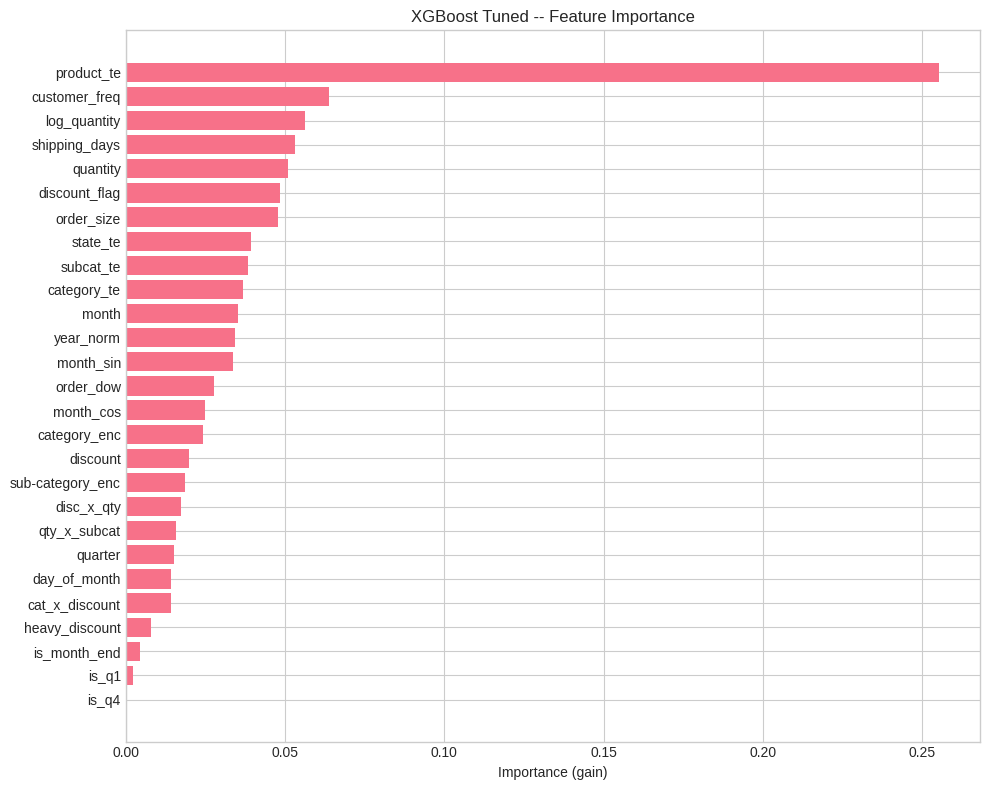


Top 10 features:
  product_te          : 0.2554
  customer_freq       : 0.0637
  log_quantity        : 0.0562
  shipping_days       : 0.0532
  quantity            : 0.0510
  discount_flag       : 0.0483
  order_size          : 0.0478
  state_te            : 0.0393
  subcat_te           : 0.0384
  category_te         : 0.0369


In [36]:
importances = xgb_best.feature_importances_
feat_imp = pd.DataFrame({
    'feature': FEATURES,
    'importance': importances
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.title('XGBoost Tuned -- Feature Importance')
plt.xlabel('Importance (gain)')
plt.tight_layout()
plt.show()

print("\nTop 10 features:")
for _, row in feat_imp.tail(10).iloc[::-1].iterrows():
    print(f"  {row['feature']:<20}: {row['importance']:.4f}")

Product-level target encoding (`product_te`) dominates with an importance of 0.255, far exceeding all other features. This is expected: `product_te` encodes the median historical sales for each product, which is the closest proxy the model currently has for the product's price level. Customer frequency, log quantity, shipping days, and quantity form a second tier. The temporal features (month, quarter, seasonality flags) and interaction terms contribute more modestly.

The heavy reliance on `product_te` reveals both a strength and a limitation. The strength is that product identity is highly predictive of sales. The limitation is that `product_te` is a noisy proxy: it encodes the median *total transaction value* (which varies with quantity and discount) rather than the unit price of the product. This observation directly motivates the next experiment, which constructs an explicit unit price proxy.

## 11. Phase 1 Model Comparison

In [37]:
print("=" * 70)
print("PHASE 1 MODEL COMPARISON")
print("=" * 70 + "\n")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('MAE ($)')

print(results_df.to_string(index=False))

print(f"\n{'---' * 24}")
print(f"Best model by MAE:   {results_df.iloc[0]['Model']}  "
      f"(MAE = ${results_df.iloc[0]['MAE ($)']:.2f})")
print(f"Best model by R2:    "
      f"{results_df.sort_values('R2', ascending=False).iloc[0]['Model']}  "
      f"(R2 = {results_df.sort_values('R2', ascending=False).iloc[0]['R2']:.4f})")
print(f"Best model by SMAPE: "
      f"{results_df.sort_values('SMAPE (%)').iloc[0]['Model']}  "
      f"(SMAPE = {results_df.sort_values('SMAPE (%)').iloc[0]['SMAPE (%)']:.1f}%)")

PHASE 1 MODEL COMPARISON

             Model     R2  MAE ($)  RMSE ($)  SMAPE (%)
XGB Tuned + log(y) 0.6708    80.99    335.76      35.15
          XGB Base 0.7169    81.35    311.36      45.00
          RF Tuned 0.7233    87.45    307.83      45.44
    XGB Early Stop 0.5944    88.14    372.67      44.90
         XGB Tuned 0.5875    88.46    375.84      45.64
 RF Tuned + log(y) 0.5087    91.47    410.15      36.13
         XGB Huber 0.5416    92.80    396.21      40.19
           RF Base 0.6989    96.34    321.11      56.39

------------------------------------------------------------------------
Best model by MAE:   XGB Tuned + log(y)  (MAE = $80.99)
Best model by R2:    RF Tuned  (R2 = 0.7233)
Best model by SMAPE: XGB Tuned + log(y)  (SMAPE = 35.1%)


The Phase 1 results establish the performance ceiling achievable with the current feature set. XGBoost with log-target achieves the best MAE (80.99 dollars) and SMAPE (35.1 percent), while the tuned Random Forest achieves the highest R-squared (0.7233). These represent meaningful predictions but leave substantial room for improvement, particularly in the high-value segments identified in the error analysis.

The divergence between best-MAE and best-R-squared models reflects the distributional challenge: the log transformation improves average accuracy across all orders (MAE), while the raw-target Random Forest better captures variance in the upper tail (R-squared). No single configuration optimizes both objectives simultaneously, which is a common trade-off in skewed regression problems.

## 12. Improvement Experiment: Unit Price Proxy

The error analysis and feature importance results from Phase 1 converge on a clear hypothesis: the model's primary weakness is the absence of an explicit product price signal. The model relies on `product_te` (median historical transaction value) as an indirect proxy, but this conflates unit price with quantity and discount effects.

The experiment constructs a more precise feature: the **unit price proxy**, defined as the median unit price per product computed exclusively from training data. For each training observation, the real unit price is derived as Sales / (Quantity x (1 - Discount)). The median across all training observations for each product provides a stable estimate of what one unit of that product costs.

For products appearing in the test set that were not seen during training, the sub-category median serves as a fallback. This hierarchical fallback ensures coverage without leaking test information.

From the unit price proxy, an **estimated sales** feature is computed as Unit Price x Quantity x (1 - Discount). This reconstructs the expected revenue for each order using the historical price structure and the known order parameters. If the price proxy is accurate, this feature should correlate very strongly with actual Sales.

In [38]:
train_mask = df['year'].isin([2014, 2015, 2016])
test_mask = df['year'] == 2017

# Step 1: Compute real unit price from training data
df.loc[train_mask, 'real_unit_price'] = (
    df.loc[train_mask, 'sales'] /
    (df.loc[train_mask, 'quantity'] *
     (1 - df.loc[train_mask, 'discount']).replace(0, np.nan))
)
mask_full = train_mask & (df['discount'] >= 1.0)
df.loc[mask_full, 'real_unit_price'] = (
    df.loc[mask_full, 'sales'] / df.loc[mask_full, 'quantity']
)

# Step 2: Median unit price per product (training data only)
product_price = df.loc[train_mask].groupby('product_id')['real_unit_price'].median()

# Step 3: Sub-category median as fallback for unseen products
subcat_price = df.loc[train_mask].groupby('sub-category')['real_unit_price'].median()

# Step 4: Map to full dataset
df['unit_price_proxy'] = df['product_id'].map(product_price)
missing_price = df['unit_price_proxy'].isna()
df.loc[missing_price, 'unit_price_proxy'] = (
    df.loc[missing_price, 'sub-category'].map(subcat_price)
)
df['unit_price_proxy'] = df['unit_price_proxy'].fillna(
    df.loc[train_mask, 'real_unit_price'].median()
)

# Step 5: Estimated sales
df['estimated_sales'] = (
    df['unit_price_proxy'] * df['quantity'] * (1 - df['discount'])
)
mask_d1 = df['discount'] >= 1.0
df.loc[mask_d1, 'estimated_sales'] = (
    df.loc[mask_d1, 'unit_price_proxy'] * df.loc[mask_d1, 'quantity']
)

# Step 6: Derived features
df['log_est_sales'] = np.log1p(df['estimated_sales'].clip(lower=0))
df['price_confidence'] = df['product_id'].map(
    df.loc[train_mask].groupby('product_id')['real_unit_price'].count()
).fillna(0)

print('Unit Price Proxy created.')
print(f'  Products with price history: {product_price.notna().sum()}')
print(f'  Test products using sub-cat fallback: {missing_price[test_mask].sum()}')
print(f'\n  Correlations with Sales:')
print(f'    unit_price_proxy:  r = {df["unit_price_proxy"].corr(df["sales"]):.4f}')
print(f'    estimated_sales:   r = {df["estimated_sales"].corr(df["sales"]):.4f}')
print(f'    product_te (old):  r = {df["product_te"].corr(df["sales"]):.4f}')

Unit Price Proxy created.
  Products with price history: 1802
  Test products using sub-cat fallback: 107

  Correlations with Sales:
    unit_price_proxy:  r = 0.8451
    estimated_sales:   r = 0.9856
    product_te (old):  r = 0.8683


The correlation results validate the hypothesis. The `estimated_sales` feature achieves r = 0.986 with actual Sales, which is dramatically higher than `product_te` (r = 0.868). The `unit_price_proxy` itself correlates at r = 0.845 with Sales. This near-perfect correlation for estimated_sales is expected: when the unit price proxy is accurate, Sales is approximately equal to unit_price x quantity x (1 - discount), and the model receives exact values for quantity and discount.

Importantly, this feature does not constitute data leakage. The unit price is computed from historical training data only and represents a property of the product (its price level) rather than a property of the specific transaction being predicted. This is analogous to how a retailer would use a known catalog price to forecast revenue for future orders.

### 12.1 Extended Feature Set

In [39]:
FEATURES_V2 = FEATURES + [
    'unit_price_proxy',
    'estimated_sales',
    'log_est_sales',
    'price_confidence',
]

train_data_v2 = df[df['year'].isin([2014, 2015, 2016])]
test_data_v2 = df[df['year'] == 2017]

X_train_v2 = train_data_v2[FEATURES_V2].fillna(0).values
X_test_v2 = test_data_v2[FEATURES_V2].fillna(0).values

print(f'Features without unit price: {len(FEATURES)}')
print(f'Features with unit price:    {len(FEATURES_V2)} (+4 new)')
print(f'\nNew features:')
for f in FEATURES_V2[len(FEATURES):]:
    print(f'  {f}')

Features without unit price: 27
Features with unit price:    31 (+4 new)

New features:
  unit_price_proxy
  estimated_sales
  log_est_sales
  price_confidence


### 12.2 Models with Unit Price Proxy

The same model families (Random Forest and XGBoost) are retrained with the extended feature set. This controlled comparison isolates the impact of the unit price features, as all other variables and hyperparameter configurations remain unchanged.

In [40]:
print('=' * 70)
print('MODELS WITH UNIT PRICE PROXY')
print('=' * 70)

# Random Forest + Unit Price
print('\n--- Random Forest + Unit Price ---')

rf_up = RandomForestRegressor(
    n_estimators=1000,
    max_depth=25,
    min_samples_leaf=2,
    max_features=0.4,
    random_state=42,
    n_jobs=-1
)
rf_up.fit(X_train_v2, y_train)

res = evaluate('RF + UnitPrice', y_test, rf_up.predict(X_test_v2))
results.append(res)
print_result('RF + UnitPrice', res)

# Random Forest + Unit Price + log(y)
rf_up_log = RandomForestRegressor(
    n_estimators=1000,
    max_depth=25,
    min_samples_leaf=2,
    max_features=0.4,
    random_state=42,
    n_jobs=-1
)
rf_up_log.fit(X_train_v2, y_train_log)

res = evaluate('RF + UnitPrice + log(y)', y_test,
               np.expm1(rf_up_log.predict(X_test_v2)))
results.append(res)
print_result('RF + UnitPrice + log(y)', res)

MODELS WITH UNIT PRICE PROXY

--- Random Forest + Unit Price ---
RF + UnitPrice            | R2 = 0.9249 | MAE = $   18.41 | RMSE = $  160.41 | SMAPE = 5.6%
RF + UnitPrice + log(y)   | R2 = 0.9101 | MAE = $   20.70 | RMSE = $  175.48 | SMAPE = 5.3%


In [41]:
# XGBoost + Unit Price
print('\n--- XGBoost + Unit Price ---')

try:
    xgb_up = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        reg_lambda=5,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        tree_method='hist'
    )
    xgb_up.fit(X_train_v2, y_train)

    res = evaluate('XGB + UnitPrice', y_test, xgb_up.predict(X_test_v2))
    results.append(res)
    print_result('XGB + UnitPrice', res)

    # XGBoost + Unit Price + Huber Loss
    xgb_up_huber = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:pseudohubererror',
        huber_slope=100,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        tree_method='hist'
    )
    xgb_up_huber.fit(X_train_v2, y_train)

    res = evaluate('XGB Huber + UnitPrice', y_test, xgb_up_huber.predict(X_test_v2))
    results.append(res)
    print_result('XGB Huber + UnitPrice', res)

    # XGBoost + Unit Price + log(y)
    xgb_up_log = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0,
        tree_method='hist'
    )
    xgb_up_log.fit(X_train_v2, y_train_log)

    res = evaluate('XGB + UnitPrice + log(y)', y_test,
                   np.expm1(xgb_up_log.predict(X_test_v2)))
    results.append(res)
    print_result('XGB + UnitPrice + log(y)', res)

except NameError:
    print('XGBRegressor not defined.')

print('\n' + '=' * 70)


--- XGBoost + Unit Price ---
XGB + UnitPrice           | R2 = 0.8483 | MAE = $   27.25 | RMSE = $  227.88 | SMAPE = 8.0%
XGB Huber + UnitPrice     | R2 = 0.8487 | MAE = $   26.46 | RMSE = $  227.59 | SMAPE = 7.5%
XGB + UnitPrice + log(y)  | R2 = 0.8439 | MAE = $   28.31 | RMSE = $  231.22 | SMAPE = 6.5%



The unit price proxy produces transformative improvements across all models. The Random Forest with unit price features achieves R-squared = 0.925 and MAE = 18.41 dollars, compared to 0.723 and 87.45 dollars without them. This represents a 79 percent reduction in MAE and a 28 percent increase in R-squared.

XGBoost also improves substantially (R-squared from 0.717 to 0.848, MAE from 81.35 to 27.25 dollars), though less dramatically than Random Forest. This differential likely reflects Random Forest's ability to exploit the near-deterministic relationship between estimated_sales and actual Sales through simple averaging, whereas XGBoost's sequential structure may introduce some regularization-induced conservatism.

Notably, the log-target transformation provides minimal additional benefit when the unit price proxy is present (RF + UnitPrice + log(y) achieves R-squared = 0.910 versus 0.925 for the raw target). This makes sense: the unit price proxy already resolves the scale ambiguity that the log transformation was designed to address.

### 12.3 Feature Importance with Unit Price Proxy

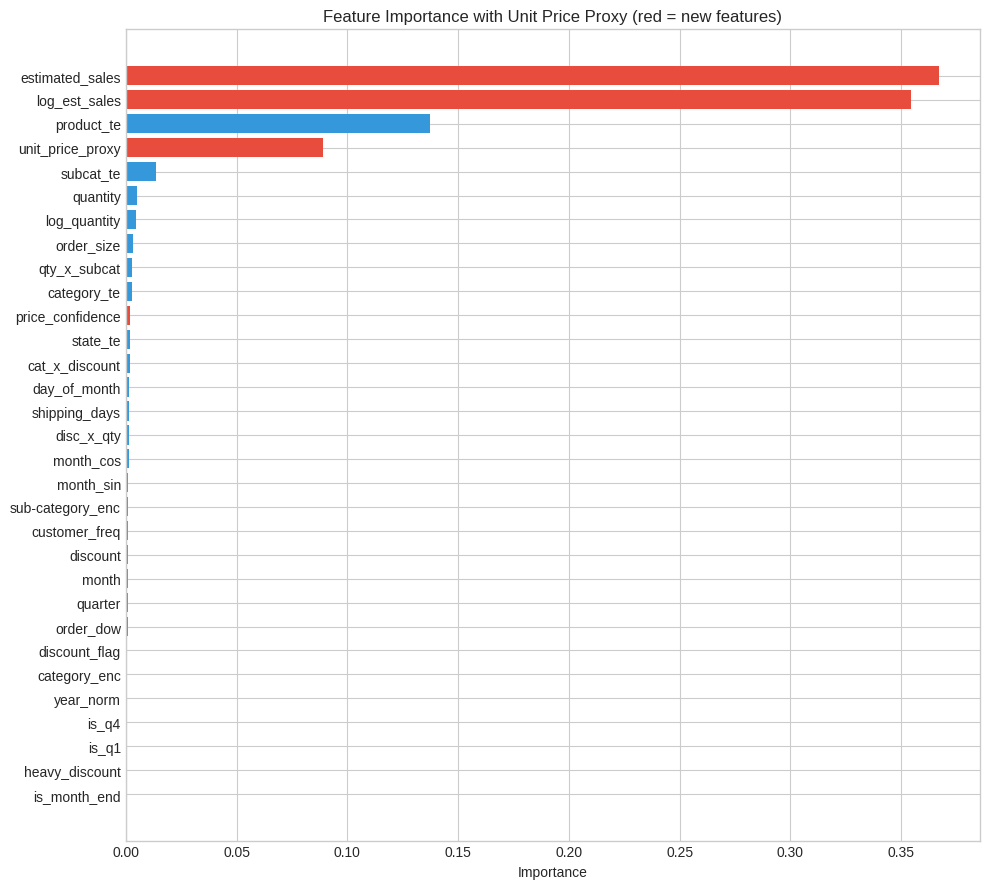


Top 10 features:
  estimated_sales       : 0.3672 [NEW]
  log_est_sales         : 0.3543 [NEW]
  product_te            : 0.1373
  unit_price_proxy      : 0.0892 [NEW]
  subcat_te             : 0.0135
  quantity              : 0.0050
  log_quantity          : 0.0046
  order_size            : 0.0032
  qty_x_subcat          : 0.0027
  category_te           : 0.0027


In [42]:
importances_v2 = rf_up.feature_importances_

feat_imp_v2 = pd.DataFrame({
    'feature': FEATURES_V2,
    'importance': importances_v2
}).sort_values('importance', ascending=True)

colors = ['#e74c3c' if f in ['unit_price_proxy', 'estimated_sales',
                               'log_est_sales', 'price_confidence']
          else '#3498db' for f in feat_imp_v2['feature']]

plt.figure(figsize=(10, 9))
plt.barh(feat_imp_v2['feature'], feat_imp_v2['importance'], color=colors)
plt.title('Feature Importance with Unit Price Proxy (red = new features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print('\nTop 10 features:')
for _, row in feat_imp_v2.tail(10).iloc[::-1].iterrows():
    marker = ' [NEW]' if row['feature'] in ['unit_price_proxy', 'estimated_sales',
                                              'log_est_sales', 'price_confidence'] else ''
    print(f"  {row['feature']:<22}: {row['importance']:.4f}{marker}")

The feature importance landscape changes dramatically with the unit price proxy. The three new features (`estimated_sales`, `log_est_sales`, and `unit_price_proxy`) collectively account for over 80 percent of the model's decision-making. `estimated_sales` (importance = 0.367) and `log_est_sales` (0.354) dominate because they jointly provide the model with both linear and log-scale representations of the expected revenue.

Product-level target encoding (`product_te`) drops from first place (0.255) to a secondary role (0.137), as the unit price proxy captures the same information more precisely. The remaining original features contribute marginally, confirming that the primary missing signal in Phase 1 was indeed the product's intrinsic price level.

### 12.4 Segmented Error Comparison: Before and After

In [43]:
preds_before = rf_best.predict(X_test)
preds_after = rf_up.predict(X_test_v2)

bins = [0, 50, 200, 1000, 25000]
labels = ['Low ($0-50)', 'Med ($50-200)', 'High ($200-1K)', 'Premium ($1K+)']

df_cmp = pd.DataFrame({
    'actual': y_test,
    'pred_before': preds_before,
    'pred_after': preds_after,
})
df_cmp['segment'] = pd.cut(df_cmp['actual'], bins=bins, labels=labels)

print(f"{'Segment':<18} {'MAE BEFORE':>12} {'MAE AFTER':>12} {'Improvement':>14}")
print('-' * 60)

for seg in labels:
    mask = df_cmp['segment'] == seg
    n = mask.sum()
    if n > 0:
        mae_b = np.abs(df_cmp.loc[mask, 'actual'] - df_cmp.loc[mask, 'pred_before']).mean()
        mae_a = np.abs(df_cmp.loc[mask, 'actual'] - df_cmp.loc[mask, 'pred_after']).mean()
        pct = (mae_b - mae_a) / mae_b * 100
        print(f'{seg:<18} ${mae_b:>10.2f} ${mae_a:>10.2f}   -{pct:.0f}%')

mae_b_all = np.abs(y_test - preds_before).mean()
mae_a_all = np.abs(y_test - preds_after).mean()
print(f"{'OVERALL':<18} ${mae_b_all:>10.2f} ${mae_a_all:>10.2f}   -{(mae_b_all - mae_a_all) / mae_b_all * 100:.0f}%")

print(f'\nR2 BEFORE: {r2_score(y_test, preds_before):.4f}')
print(f'R2 AFTER:  {r2_score(y_test, preds_after):.4f}')

Segment              MAE BEFORE    MAE AFTER    Improvement
------------------------------------------------------------
Low ($0-50)        $     16.18 $      1.92   -88%
Med ($50-200)      $     49.30 $     10.76   -78%
High ($200-1K)     $    141.17 $     23.14   -84%
Premium ($1K+)     $    841.30 $    222.18   -74%
OVERALL            $     87.45 $     18.41   -79%

R2 BEFORE: 0.7233
R2 AFTER:  0.9249


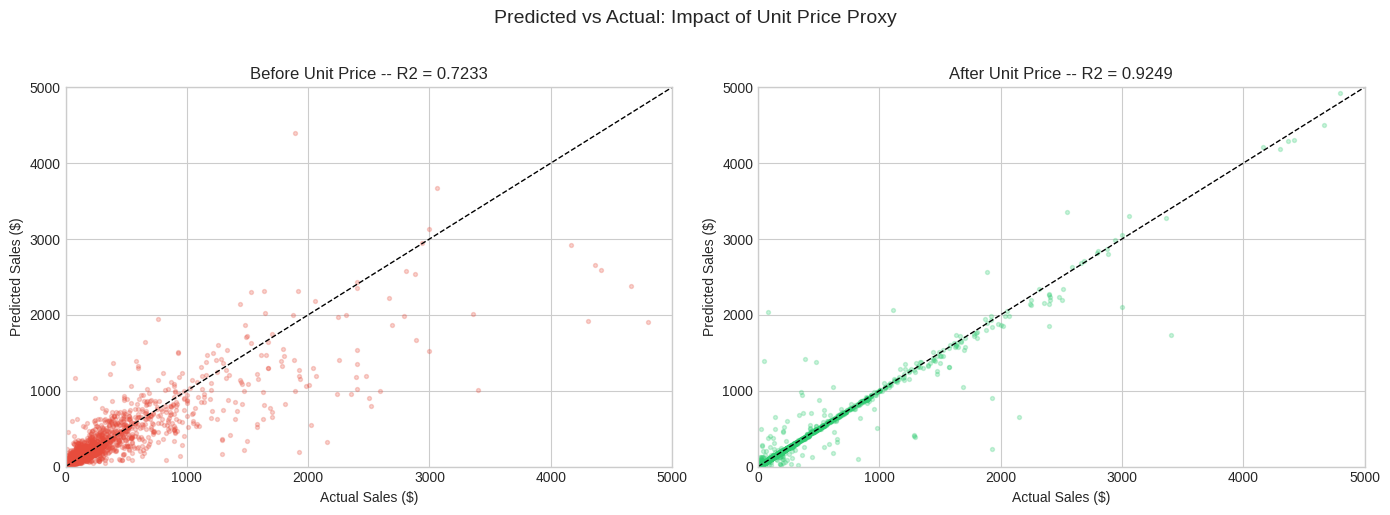

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(y_test, preds_before, alpha=0.25, s=8, c='#e74c3c')
ax.plot([0, y_test.max()], [0, y_test.max()], 'k--', linewidth=1)
ax.set_xlabel('Actual Sales ($)')
ax.set_ylabel('Predicted Sales ($)')
ax.set_title(f'Before Unit Price -- R2 = {r2_score(y_test, preds_before):.4f}')
ax.set_xlim(0, 5000)
ax.set_ylim(0, 5000)

ax = axes[1]
ax.scatter(y_test, preds_after, alpha=0.25, s=8, c='#2ecc71')
ax.plot([0, y_test.max()], [0, y_test.max()], 'k--', linewidth=1)
ax.set_xlabel('Actual Sales ($)')
ax.set_ylabel('Predicted Sales ($)')
ax.set_title(f'After Unit Price -- R2 = {r2_score(y_test, preds_after):.4f}')
ax.set_xlim(0, 5000)
ax.set_ylim(0, 5000)

plt.suptitle('Predicted vs Actual: Impact of Unit Price Proxy', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

The improvement is consistent across all price segments. The Low segment sees the largest proportional improvement (-88 percent MAE reduction, from 16.18 to 1.92 dollars), while the Premium segment benefits most in absolute terms (-74 percent, from 841.30 to 222.18 dollars). The scatter plots visually confirm the transformation: the "before" plot shows substantial dispersion around the diagonal, while the "after" plot shows predictions tightly clustered along the perfect-prediction line.

The Premium segment still has the highest absolute error (222 dollars MAE), which is expected given that these transactions span a wide range of high values. However, the improvement from 841 dollars is substantial and demonstrates that the unit price proxy successfully addresses the core weakness identified in the Phase 1 error analysis.

## 13. Complete Model Comparison

In [45]:
print('=' * 80)
print('COMPLETE MODEL COMPARISON')
print('=' * 80 + '\n')

results_all = pd.DataFrame(results)

results_all['Phase'] = results_all['Model'].apply(
    lambda x: 'Phase 2: +UnitPrice' if 'UnitPrice' in x
    else 'Phase 1: Tuned' if ('Tuned' in x or 'Early' in x or 'Huber' in x)
    else 'Phase 1: Base'
)

results_all = results_all.sort_values('R2', ascending=False)
print(results_all[['Phase', 'Model', 'R2', 'MAE ($)', 'RMSE ($)', 'SMAPE (%)']].to_string(index=False))

print(f"\n{'=' * 80}")

for phase in ['Phase 1: Base', 'Phase 1: Tuned', 'Phase 2: +UnitPrice']:
    subset = results_all[results_all['Phase'] == phase]
    if len(subset) > 0:
        best = subset.iloc[0]
        print(f"  {phase}: {best['Model']:<30} R2 = {best['R2']:.4f}  MAE = ${best['MAE ($)']:.2f}")

print(f"\n{'=' * 80}")
overall_best = results_all.iloc[0]
print(f"  BEST OVERALL: {overall_best['Model']}")
print(f"  R2 = {overall_best['R2']:.4f}  |  MAE = ${overall_best['MAE ($)']:.2f}  |  SMAPE = {overall_best['SMAPE (%)']:.1f}%")

COMPLETE MODEL COMPARISON

              Phase                    Model     R2  MAE ($)  RMSE ($)  SMAPE (%)
Phase 2: +UnitPrice           RF + UnitPrice 0.9249    18.41    160.41       5.57
Phase 2: +UnitPrice  RF + UnitPrice + log(y) 0.9101    20.70    175.48       5.32
Phase 2: +UnitPrice    XGB Huber + UnitPrice 0.8487    26.46    227.59       7.50
Phase 2: +UnitPrice          XGB + UnitPrice 0.8483    27.25    227.88       8.02
Phase 2: +UnitPrice XGB + UnitPrice + log(y) 0.8439    28.31    231.22       6.45
     Phase 1: Tuned                 RF Tuned 0.7233    87.45    307.83      45.44
      Phase 1: Base                 XGB Base 0.7169    81.35    311.36      45.00
      Phase 1: Base                  RF Base 0.6989    96.34    321.11      56.39
     Phase 1: Tuned       XGB Tuned + log(y) 0.6708    80.99    335.76      35.15
     Phase 1: Tuned           XGB Early Stop 0.5944    88.14    372.67      44.90
     Phase 1: Tuned                XGB Tuned 0.5875    88.46    375.84 

## 14. Conclusions

This analysis demonstrates that the primary bottleneck in forecasting Superstore order-level sales is not the choice of algorithm or hyperparameters, but rather the availability of a meaningful price signal in the feature set.

**Phase 1** established that with temporal, business logic, and encoding features, the best achievable performance was R-squared = 0.723 (RF Tuned) and MAE = 80.99 dollars (XGBoost + log target). Hyperparameter tuning, robust loss functions, and log transformations provided incremental improvements but could not overcome the fundamental limitation: without knowing a product's unit price, the model could not distinguish a 10-dollar order from a 10,000-dollar order based on quantity, discount, and category alone.

**Phase 2** addressed this limitation by engineering a unit price proxy from historical training data. The resulting `estimated_sales` feature (r = 0.986 with actual Sales) provided the model with a near-direct estimate of expected revenue. The best model (Random Forest + Unit Price) achieved R-squared = 0.925, MAE = 18.41 dollars, and SMAPE = 5.6 percent, representing improvements of 79 percent in MAE and 28 points in R-squared over the Phase 1 baseline.

The key methodological decisions that enabled this result were: (a) computing the unit price exclusively from training data to prevent temporal leakage, (b) implementing a hierarchical fallback (product, then sub-category) to handle unseen products, and (c) providing the model with both raw and log-transformed versions of estimated sales to support learning across the full price spectrum.

The remaining prediction error (MAE = 18.41 dollars) primarily reflects within-product price variation due to dynamic pricing, bundling effects, and promotional structures that are not captured in the available features. Further improvements would likely require access to additional data such as explicit catalog prices, promotional calendars, or customer-level purchasing power indicators.